<a href="https://colab.research.google.com/github/tomasdfen/AADLIS/blob/main/Pruebas_TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

TEST_PERCENTAGE = 0.2
VAL_PERCENTAGE = 0.1
LAG = 15
PREDICT_WINDOW=20

### Leemos los datos, dandole al indice formato de fecha asociada

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Datos.xlsx', parse_dates=True, index_col=0)
print(df.shape)
df.head()

(498318, 24)


,AFN01,AFN02,AFN03,AFN04,AFN05,AFN06,AFN07,AFN08,AFN09,AFN10,AFN11,AFN12,AFN13,AFN14,AFN15,AFN16,AFN17,AFN18,AFN19,AFN20,AFN21,AFN22,AFN23,AFN24
Time (hh:mm:ss.ms),,,,,,,,,,,,,,,,,,,,,,,,
2021-02-17 05:55:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-17 05:56:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-17 05:57:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-17 05:58:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-02-17 05:59:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Dividimos el conjunto de datos en función de la fecha

In [3]:
test_cutoff_date = df.index[int(len(df.index)* (1 - TEST_PERCENTAGE - VAL_PERCENTAGE))]
val_cutoff_date = df.index[int(len(df.index) * (1 - VAL_PERCENTAGE))]

In [4]:
train = df.loc[:test_cutoff_date]
test = df.loc[test_cutoff_date:val_cutoff_date]
val = df.loc[val_cutoff_date:]

Mostramos el tamaño de cada conjunto

In [5]:
print(f"Tamaño del conjunto de entrenamiento: {train.shape}")
print(f"Tamaño del conjunto de test: {test.shape}")
print(f"Tamaño del conjunto de validación: {val.shape}")

Tamaño del conjunto de entrenamiento: (348823, 24)
Tamaño del conjunto de test: (99665, 24)
Tamaño del conjunto de validación: (49832, 24)


In [8]:
def preprocess(dataset: pd.DataFrame, lag : int = 15, predict_window : int = 20):
    temp = dataset.copy()
    temp.columns = ["t"]
    for i in range(1,lag):
        temp.insert(0, f"t-{i}", temp["t"].shift(i))
    temp = temp[lag+predict_window:]
    columns = temp.columns[:]
    
    temp_x = pd.DataFrame(MinMaxScaler().fit_transform(temp.values))
    temp_x.columns = columns

    temp_y = temp.t
    return temp_x, temp_y

In [9]:
x_train, y_train = preprocess(pd.DataFrame(train.AFN01))

In [10]:
x_train

,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.001022,0.000000,0.001024,0.000000,0.000000,0.001025,0.000000,0.001026,0.000000,0.001027,0.000000,0.000000,0.001028
2,0.000000,0.001022,0.001022,0.001024,0.001024,0.000000,0.001025,0.001025,0.001026,0.001026,0.001027,0.001027,0.000000,0.001028,0.001028
3,0.001022,0.001022,0.002045,0.001024,0.001024,0.001025,0.001025,0.002049,0.001026,0.002051,0.001027,0.001027,0.001028,0.001028,0.001028
4,0.001022,0.002045,0.002045,0.001024,0.002047,0.001025,0.002049,0.002049,0.002051,0.002051,0.001027,0.002053,0.001028,0.001028,0.002055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348783,0.789366,0.789366,0.789366,0.789150,0.789150,0.788934,0.788934,0.788934,0.793846,0.793846,0.793634,0.793634,0.793422,0.793422,0.793422
348784,0.789366,0.789366,0.789366,0.789150,0.789150,0.788934,0.788934,0.794057,0.793846,0.793846,0.793634,0.793634,0.793422,0.793422,0.793422
348785,0.789366,0.789366,0.789366,0.789150,0.789150,0.788934,0.794057,0.794057,0.793846,0.793846,0.793634,0.793634,0.793422,0.793422,0.793422
348786,0.789366,0.789366,0.789366,0.789150,0.789150,0.794057,0.794057,0.794057,0.793846,0.793846,0.793634,0.793634,0.793422,0.793422,0.793422


In [11]:
y_train

Time (hh:mm:ss.ms)
2021-02-17 06:30:00.000      8
2021-02-17 06:31:00.000      9
2021-02-17 06:32:00.000      9
2021-02-17 06:33:00.000      9
2021-02-17 06:34:00.000     10
                          ... 
2021-02-17 12:42:40.580    780
2021-02-17 12:42:40.620    780
2021-02-17 12:42:40.700    780
2021-02-17 12:42:40.720    780
2021-02-17 12:42:40.740    780
Name: t, Length: 348788, dtype: int64

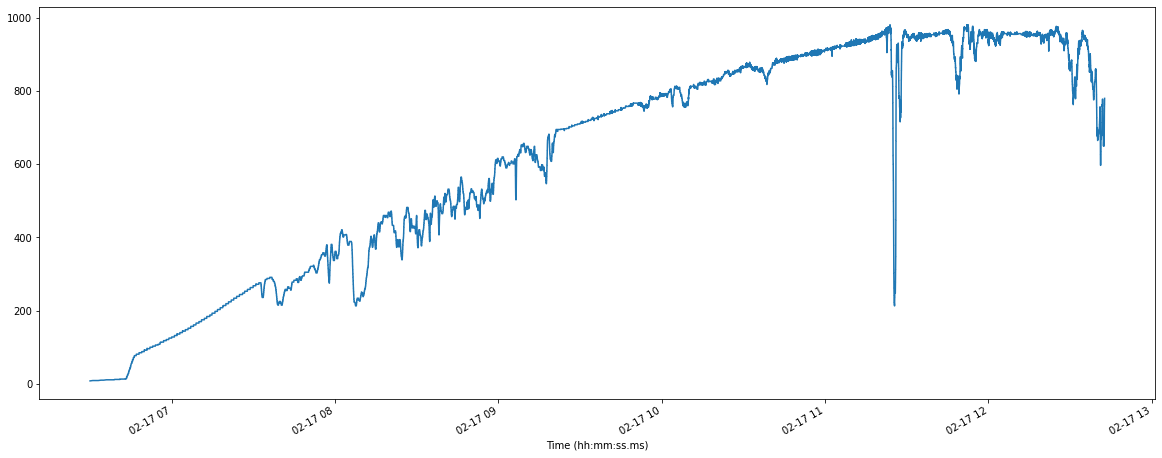

In [12]:
y_train.plot(figsize=(20,8))

In [28]:
x_val, y_val = preprocess(pd.DataFrame(val.AFN01))

In [29]:
val_data = (x_val.values.reshape(*x_val.shape, 1), y_val)

In [58]:
input = Input((LAG,1))
hidden = LSTM(32, return_sequences=True)(input)
output = Dense(1, activation='linear')(hidden)

model = Model(input, output)

In [59]:
model.compile(loss="mse", optimizer="SGD", metrics="mae")

In [60]:
model.fit(x=x_train.values.reshape(*x_train.shape, 1), y=y_train,epochs=2, validation_data=val_data)

Epoch 1/2
10900/10900 [==============================] - 79s 7ms/step - loss: 12545.4270 - mae: 66.2441 - val_loss: 4704.4600 - val_mae: 57.8012
Epoch 2/2
10900/10900 [==============================] - 77s 7ms/step - loss: 1322.5236 - mae: 26.6016 - val_loss: 4670.0215 - val_mae: 56.3910


In [61]:
x_test, y_test = preprocess(pd.DataFrame(test.AFN01))

In [62]:
predicts = model.predict(x=x_test.values.reshape(*x_test.shape, 1))

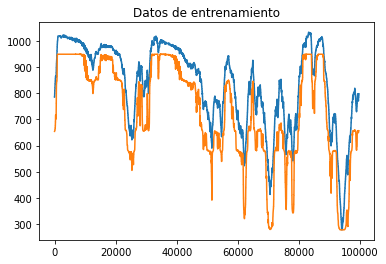

In [63]:
predicts = np.mean(predicts, axis=1)
plt.title('Datos de entrenamiento')
plt.plot(range(len(y_test)),y_test )
plt.plot(range(len(predicts)),predicts )

plt.show()